In [1]:
import pandas as pd
df = pd.read_csv('CC_GENERAL.csv',index_col='CUST_ID')
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## what is this dataset?

source: kaggle

describes the behavior of about 9000 credit holders over a period of 6 months.

it includes 18 features.

## what can we use this data for?


- we can simply use this data to learn more about our customers...no specific objective rather than building our intuitions about customer behavior.
- looking for anomolous behavior -- customers whose behavior is out of the ordinary (this is a modeling task, we'll have to specify a model)
- clustering or segmenting customers based on their behavior
- we can choose a variable of interest from among the 18 features - and model it as a function of other variables.

In [2]:
## let's cluster

# first we start with some light eda

# eda will probably uncover some data wrangling/data processing tasks

# then we'll take a shot at clustering

In [3]:
df.shape

(8950, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CRED

In [5]:
# df['CUST_ID'].nunique() == df.shape[0]

# above will throw an error after setting CUST_ID as index

## impute null values

In [6]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [7]:
df.columns = [col.lower() for col in df.columns]

In [8]:
# visual inspection of obs with missing minimum payments
df.loc[df['minimum_payments'].isna(),:].head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
CUST_ID,,,,,,,,,,,,,,,,,
C10004,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
C10047,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
C10049,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
C10056,6.660517,0.636364,310.0,0.0,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
C10057,1311.995984,1.000000,1283.9,1283.9,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12


In [9]:
import matplotlib.pyplot as plt

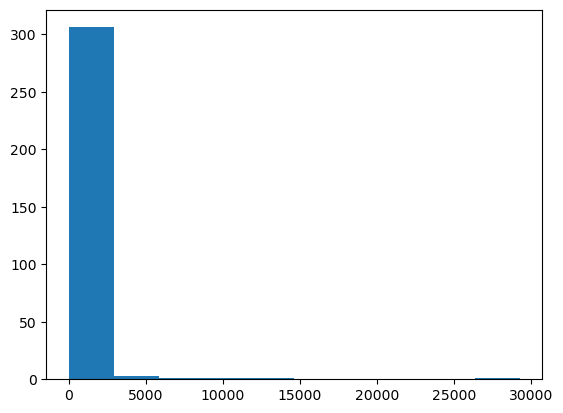

In [10]:
plt.plot()
plt.hist(df.loc[df['minimum_payments'].isna(),'payments'])
plt.show()


In [11]:
mask = (df['minimum_payments'].isna()) & (df['payments'] == 0)
df.loc[mask,:].shape[0]/313

0.7667731629392971

In [12]:
# i think there's a connection between having a missing min payment and a payments of 0

In [13]:
# we're going to impute min payments and we can take a number of different approaches

# just take the average or median of min payment data that we do have, and impute using that
# throw away the rows with missing data (reluctant to do that here)
# model based imputation (from very simple to very complex)

In [14]:
# constant of proportionality
# 1. find another one of the features that is highly correlated with min payments (e.g. "payments")
# 2. take the ratio of avg(min payments)/avg(payments) = C
# 3. and let missing min payments be defined as payments*C

# payments*C = min payments
# C = min payments / payments 
# baby linear regression

# you can of course actually do a regression and impute using that

In [15]:
df.corr()['minimum_payments'].sort_values(ascending = False)

minimum_payments                    1.000000
balance                             0.398684
cash_advance                        0.140107
balance_frequency                   0.132569
installments_purchases              0.132172
credit_limit                        0.126671
payments                            0.126651
cash_advance_trx                    0.109739
cash_advance_frequency              0.098838
purchases_trx                       0.096333
purchases                           0.093860
tenure                              0.059444
oneoff_purchases                    0.048755
purchases_installments_frequency    0.030073
purchases_frequency                 0.003030
oneoff_purchases_frequency         -0.030327
prc_full_payment                   -0.140379
Name: minimum_payments, dtype: float64

In [16]:
# constant of proportionality between balance and min payments
# avg(min payments)/avg(balance)
C = df['minimum_payments'].mean()/df['balance'].mean()
imputed_min_payments = C*df.loc[df['minimum_payments'].isna(),'balance']
print(imputed_min_payments.mean(), df['minimum_payments'].mean())

306.822465338347 864.2065423050828


In [17]:
# very quickly - let's try to impute with linear regression

from sklearn.linear_model import LinearRegression

In [18]:

predictors = df.loc[~df['minimum_payments'].isna(),:]
predictors.dropna(inplace=True)
target = predictors['minimum_payments']
predictors.drop(columns = ['minimum_payments'],inplace = True)

/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_63095/3282811061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors.dropna(inplace=True)
/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_63095/3282811061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors.drop(columns = ['minimum_payments'],inplace = True)


In [19]:
predictors.shape[0] == target.shape[0]

True

In [20]:
# before i make the model
# how do we know if the model is any good?
# do you guys know model evaluation for linear regression?
# R squared is one way
# briefly
# "percentage of the variance explained"
# "how much better is your model compared to the dummy model of always predicting the mean"
# 864 is the mean minimum payments
# naive model - always predict 864 regardless of other information you have
# interpretation - r2 0 is like always predicting the mean - and the closer you get to r2 of 1, is how much better you are than the mean

In [21]:
lm1 = LinearRegression()
lm1.fit(predictors,target)
lm1.score(predictors,target)

0.19672360257016308

In [22]:
# r2 .19

# the question is --- is this better than the previous approach? ie the constant of proportionality
# we already know it is better than always predicting the mean value

In [23]:
# calculate R squared for constant of proportionality 
# i need ground truth minimum_payments (known values of minimum payments) = y
# i also need values of minimum_payments calculated using C*balance = y_hat
# Rsquared(y,y_hat) -> we get out a value

# target
predicted_minimum_payments_using_cop = C*df.loc[(~df['minimum_payments'].isna()) & (~df['credit_limit'].isna()),'balance']

In [24]:
# r2_score(y_true, y_pred,
from sklearn.metrics import r2_score
r2_score(target,predicted_minimum_payments_using_cop)

0.1509017635738128

In [25]:
# it seems the regression is a better imputation strategy

# we need to now generate predicted values of minimum_payments for the cases where minimum_payments is null using the regression
lm1.feature_names_in_

array(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'prc_full_payment', 'tenure'],
      dtype=object)

In [26]:
df.shape[1]

17

In [27]:
# create predictor matrix (table) by filtering data for cases where minimum_payments is null
predictors_imputation = df.loc[df['minimum_payments'].isna(),:].drop(columns = ['minimum_payments'])
predictors_imputation.info()
# drop minimum_payments column
# generate predictions

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, C10004 to C19187
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance                           313 non-null    float64
 1   balance_frequency                 313 non-null    float64
 2   purchases                         313 non-null    float64
 3   oneoff_purchases                  313 non-null    float64
 4   installments_purchases            313 non-null    float64
 5   cash_advance                      313 non-null    float64
 6   purchases_frequency               313 non-null    float64
 7   oneoff_purchases_frequency        313 non-null    float64
 8   purchases_installments_frequency  313 non-null    float64
 9   cash_advance_frequency            313 non-null    float64
 10  cash_advance_trx                  313 non-null    int64  
 11  purchases_trx                     313 non-null    int64  
 12  credi

In [28]:
imputed_minimum_payments_using_lm = lm1.predict(predictors_imputation)

In [29]:
imputed_minimum_payments_using_lm.shape

(313,)

In [30]:
# overwrite the nulls in df with these 313 values
df.loc[df['minimum_payments'].isna(),'minimum_payments'] = imputed_minimum_payments_using_lm

In [31]:
df.isna().sum()

balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        1
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [32]:
df.dropna(inplace=True)

In [33]:
df.isna().sum()

balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

### inspect distributions

to-do

1. visual inspection (make a bunch of histograms)
2. note the presence of outliers
3. we need to ensure the data is on the same scale.
4. decide how to scale the data (normalize (0-1), standardize (map to normal distribution), ....)

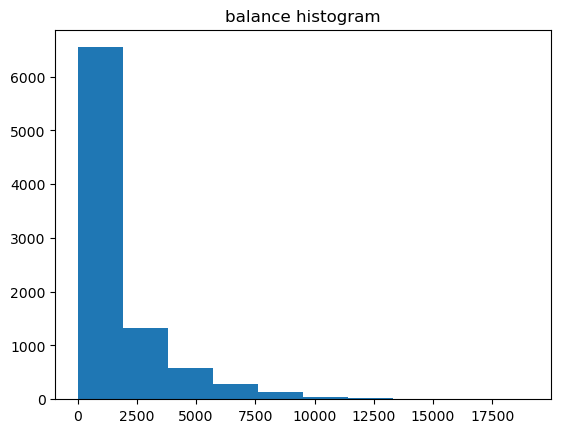

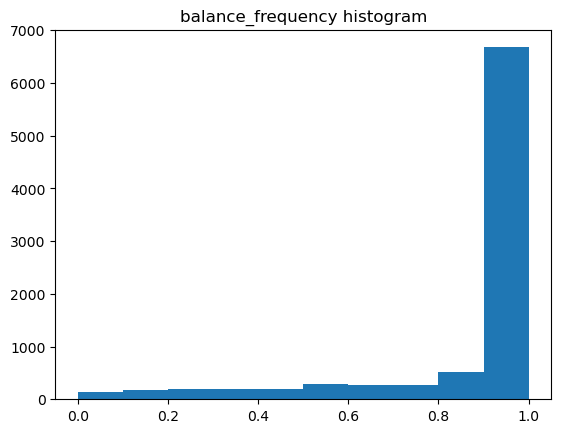

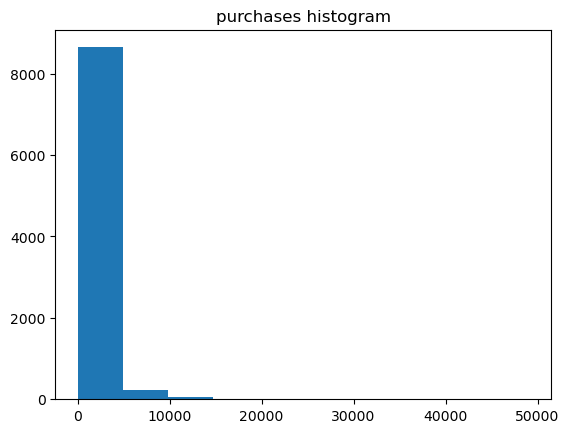

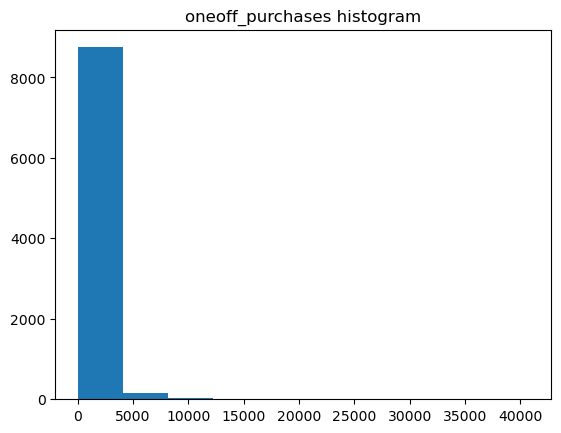

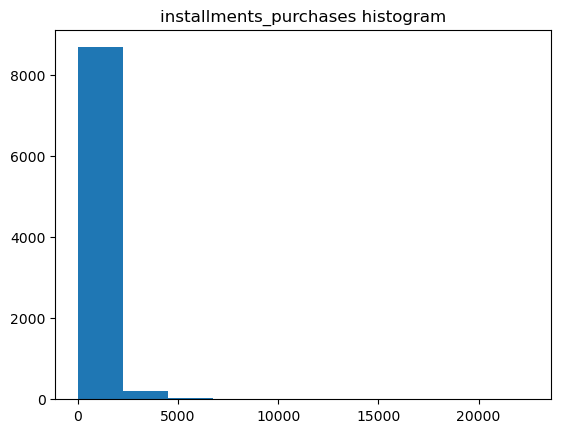

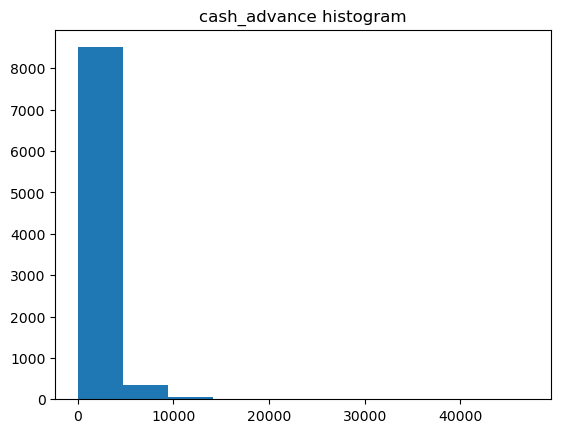

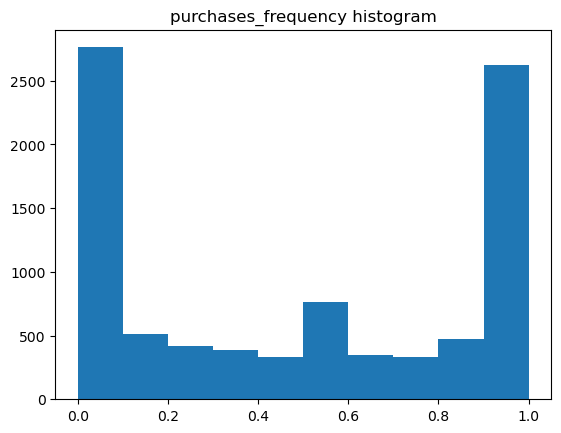

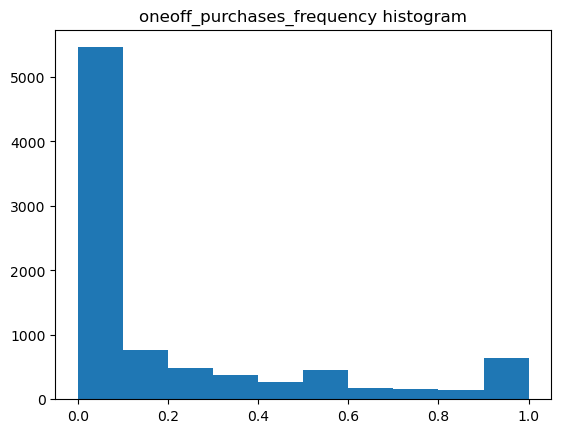

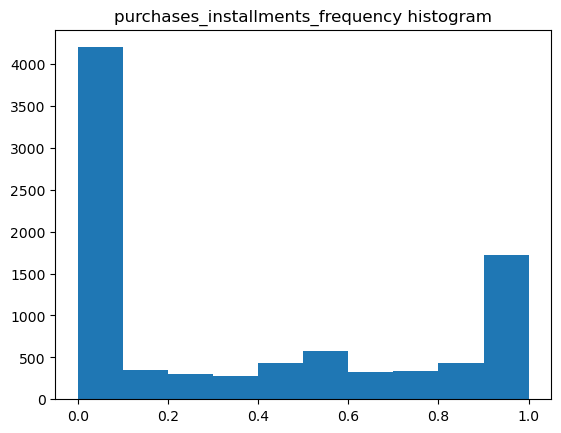

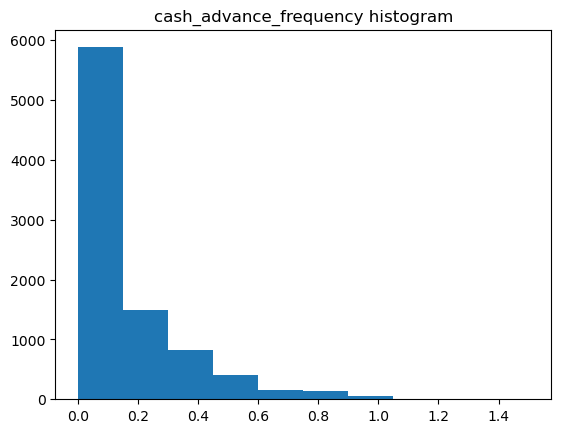

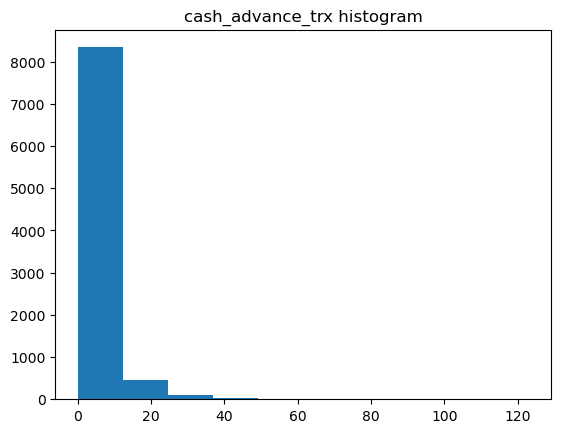

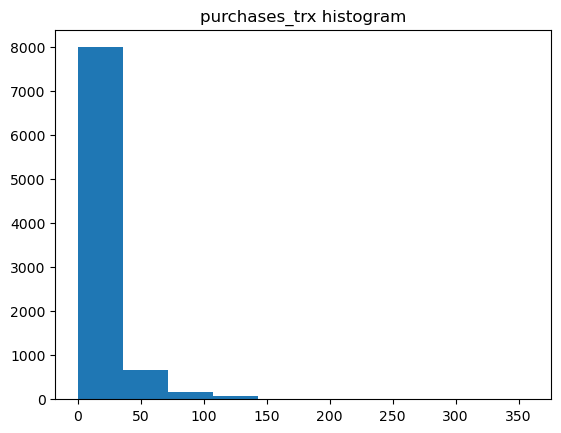

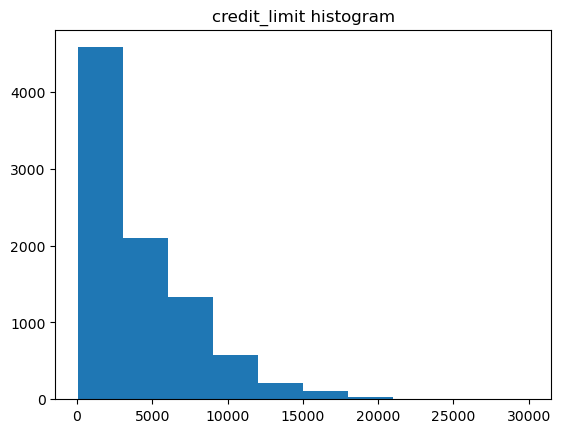

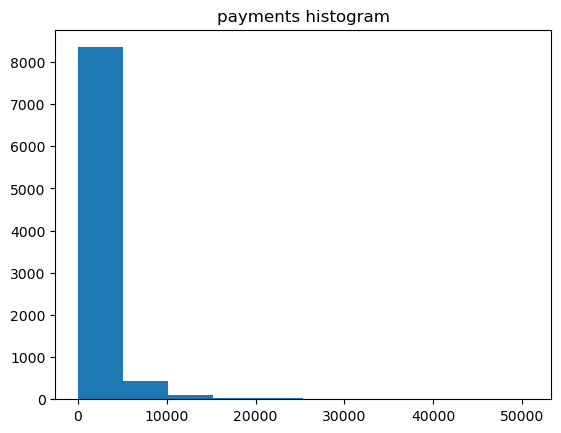

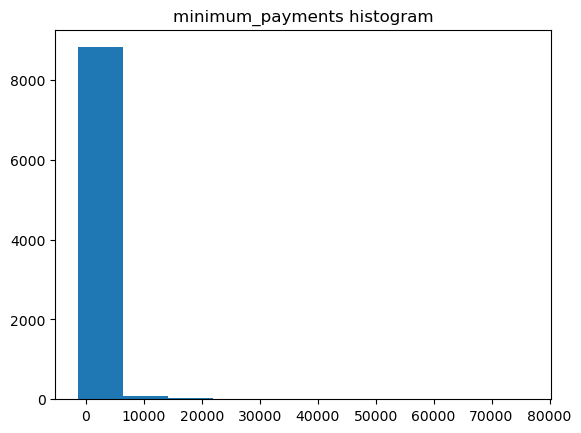

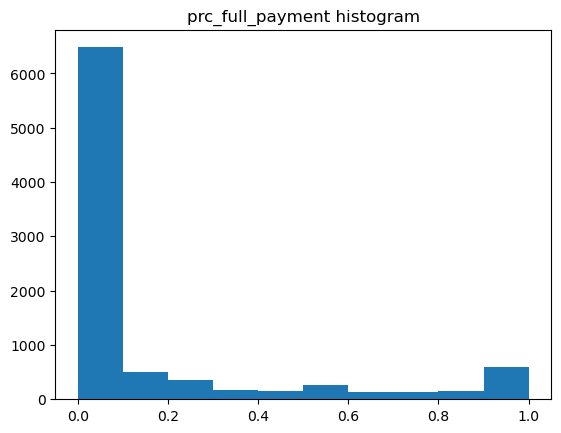

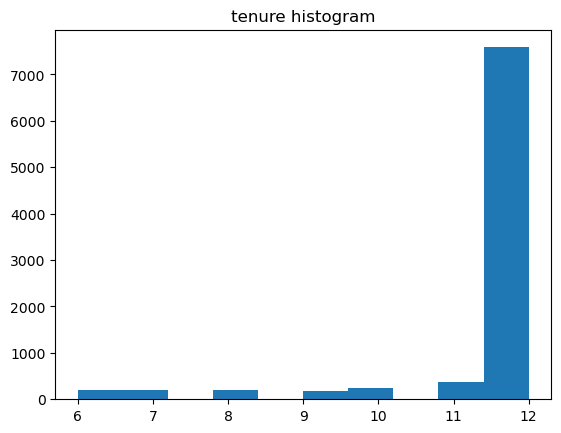

In [34]:
# make a bunch of histograms

for col in df.columns:
    plt.figure()
    plt.hist(df[col])
    plt.title(f"{col} histogram")
    plt.show()

In [35]:
# we should be clipping the extreme ends of the distribution (seems reasonable)
# windsorization
import numpy as np
from scipy.stats.mstats import winsorize

# data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100])
# winsorized_data = winsorize(data, limits=[0.1, 0.9])
# winsorized_data

In [36]:
def compare_winsorized_to_original(data,lower_limit,upper_limit):
    # first winsorize
    winsorized_data = winsorize(data,limits = [lower_limit,upper_limit])
    # then compare
    # plt.figure()
    # plt.hist(data,alpha = .5,color = "blue")
    # plt.hist(winsorized_data,alpha = .5,color = "red")
    # plt.show()
    print(f"max of original data {data.max()}\nmax of winsorized data with lower limit {lower_limit} and upper limit of {upper_limit}:{winsorized_data.max()}") 
    

In [37]:
compare_winsorized_to_original(df['minimum_payments'],.01,.999)

max of original data 76406.20752
max of winsorized data with lower limit 0.01 and upper limit of 0.999:1.519351


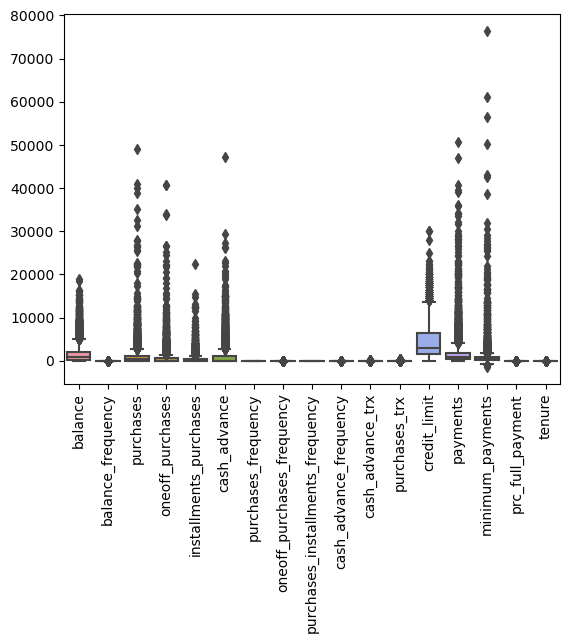

In [38]:
# 
import seaborn as sns
fig, axis = plt.subplots(1,1)
sns.boxplot(df,ax = axis)
axis.tick_params(axis = 'x',rotation = 90)


In [39]:
# how do we scale?
# we already saw that some of the variables are scaled to 0-1
# minmax scaling
# suppose your data is x = [100,39,203,...]
# x_scaled = (x - x.min)/(x.max - x.min)
# suppose x is integers between 0 and 100
# what is x_scaled to 0
# how does 0 translate to x_scaled
# 0 - 0/100 - 0 -> 0
# how does 100 translate to x_scaled
# 100 -> 1

# standard scaler - z-scoring
# hint - related to normal distribution
# mean, standard deviation are the 2 numbers that characterize any normal distribution
# suppose x is a variable in your dataset, we can calculate mean(x) = mu, sd(x) = sigma
# standard scaling maps mu -> 0 and sigma -> 1
# x_scaled = x - mean(x) / sd(x)

# robust scaler - a lot like the standard scaler
# BUT instead centering (or subtracting) with the mean and dividing by sd
# we use center with the median and divide by the IQR
# IQR = the distance between the first quartile of the date (%25 percentile) and the 3rd quartile (%75 percentile)
# x_scaled = x - median(x)/IQR(x)

# i think we should use the robust scaler


In [40]:
from sklearn.preprocessing import RobustScaler

# instantiate the thing (in this case the robustscaler)
scaler = RobustScaler()

# fit the thing (our scaler)
scaler.fit(df)

# transform the data using the thing
scaled = scaler.transform(df)

scaled = pd.DataFrame(scaled, columns = df.columns)

scaled.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-0.432387,-1.636364,-0.248596,-0.065763,0.013656,0.000000,-0.399999,-0.277777,-0.111112,0.000000,0.00,-0.3125,-0.408163,-0.431661,-0.265638,0.000000,0.0
1,1.209127,-0.818182,-0.337724,-0.065763,-0.189907,5.784296,-0.600000,-0.277777,-0.222223,1.125001,1.00,-0.4375,0.816327,2.138325,1.198697,1.555556,0.0
2,0.841881,0.000000,0.384615,1.272295,-0.189907,0.000000,0.600000,3.055557,-0.222223,0.000000,0.00,0.3125,0.918367,-0.154807,0.500059,0.000000,0.0
3,0.411728,-3.272727,1.062726,2.528425,-0.189907,0.184751,-0.500000,0.000000,-0.222223,0.374999,0.25,-0.3750,0.918367,-0.564601,0.335966,0.000000,0.0
4,-0.029058,0.000000,-0.322776,-0.038073,-0.189907,0.000000,-0.500000,0.000000,-0.222223,0.000000,0.00,-0.3750,-0.367347,-0.117739,-0.100370,0.000000,0.0


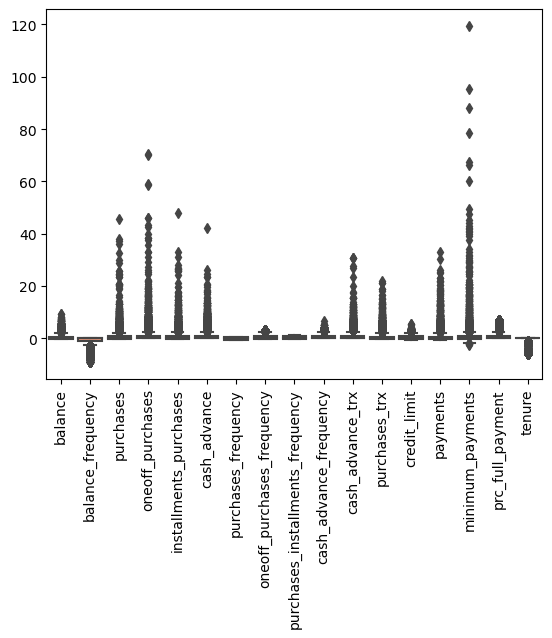

In [41]:
fig, axis = plt.subplots(1,1)
sns.boxplot(scaled,ax = axis)
axis.tick_params(axis = 'x',rotation = 90)

balance
balance_frequency
purchases
oneoff_purchases
installments_purchases
cash_advance
purchases_frequency
oneoff_purchases_frequency
purchases_installments_frequency
cash_advance_frequency
cash_advance_trx
purchases_trx
credit_limit
payments
minimum_payments
prc_full_payment
tenure


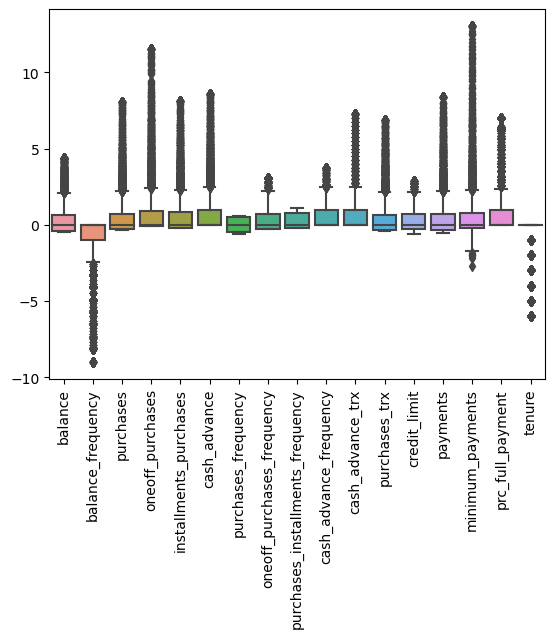

In [42]:
# cool - ready to force extreme values into a reasonable range
# winsorize to the 99th percentile -- if it turns out bad - no big deal

windsor = scaled.copy()
for col in windsor.columns:
    print(col)
    if np.max(windsor[col]) == 1.0:
        continue
    upper_limit = np.percentile(windsor[col],99)
    lower_limit = np.min(windsor[col])
    windsor[col] = np.clip(windsor[col],lower_limit,upper_limit)
    
fig, axis = plt.subplots(1,1)
sns.boxplot(windsor,ax = axis)
axis.tick_params(axis = 'x',rotation = 90)    

In [43]:
# not bad - 
# further iteration
## might include log transforming (prior to scaling) - not sure about this would need to try it both ways
## and possibly other tricks

## Clustering

first algo: K means

objective: is find clusters (find groups of data points that are more similar to each other than they are to points in other groups)

how does K means work

1. you tell K means how many clusters we want it to find (that's the K parameter)
2. it will randomly generate K points in the feature space - these are the initial "cluster centers"
3. for every data point (every customer) we calculate the distance between them and each of the cluster centers
4. the data point is then assigned to the closest cluster center
5. for each cluster center, we reposition it by calculating the average of all the points that now belong to it
6. we repeat steps 3, 4 and 5, until the cluster centers no longer move.

at the end of this we have our clustering.


In [44]:
# clustering performance metrics (we'll talk about next time) inertia, silhouette score, ...

In [45]:
# inertia lets us quantify how good our clusters are

# definition

# every cluster has a cluster center
# for every data point assigned to a cluster
# take the squared distance between it and the cluster center
# then add up these numbers
# (5,18) = cluster center (c)
# (4,17) and (3,16) are the two points in the cluster (p1,p2)
# d(c,p1)^2 + d(c,p2)^2 = sum of squared distances

# then do this for all the other clusters

# then add up all of these numbers

# inertia

# intuition

# do we want inertia to be small or large in order to believe that we have good clusters?
# we want inertia to be small

# procedure
# experiment with the k parameter
# fit a kmeans for each value of k in a range of k that you want to experiment with
# then graph k vs inertia

In [46]:
from sklearn.cluster import KMeans

ks, inertias = [], []

for k in range(1,11):
    # instantiate
    model = KMeans(n_clusters = k,n_init = 'auto')
    # fit
    model.fit(windsor)
    # score
    inertias.append(model.inertia_)
    ks.append(k)

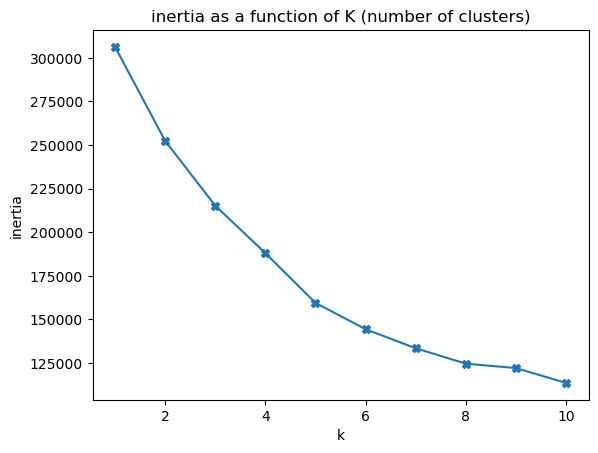

In [47]:
plt.figure()
plt.plot(ks,inertias,marker = "X")
plt.title("inertia as a function of K (number of clusters)")
plt.ylabel('inertia')
plt.xlabel('k')
plt.show()

In [48]:
# k = 5 <- this one looks the best
# k = 2
# k = 3

In [49]:
# concordance - models agree
# agglomerative clustering
# heirarchical approach
# bottom up and iterative
# https://www.drive5.com/usearch/manual/agg.html
# https://en.wikipedia.org/wiki/Hierarchical_clustering

# there's no cluster centers (at least not defined naturally, or by the algo itself)
# because of this, we can't use inertia
# luckily we have a different metric
# silhouette score (sil score)
# we will use this to evaluate agglomerative clustering

# for every point, we can calculate a sil coefficient
# then we combine these to make up the sil score

# sil coefficient for a single data point (p1)

# a(p1) = average distance between p1 and the other points in the cluster it belongs to
# b(p1) = average distance between p1 and the points in the closest cluster that it does not belong to

# s(p1) = (b - a)/max(a,b)

# we calculate the coefficient for every single data point 

# then we take the mean to get the sil score

# do we want the sil score to be large or small


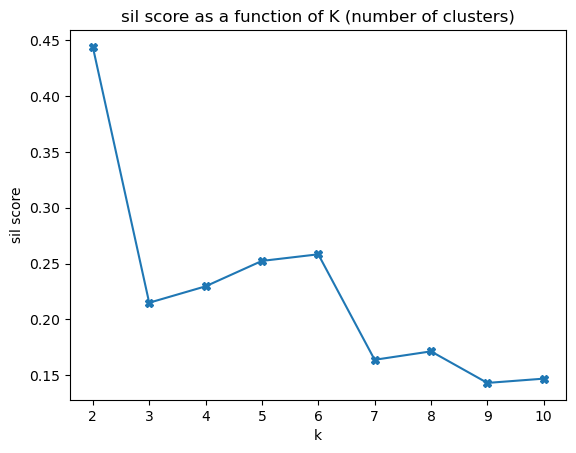

In [50]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

ks, sil_scores = [], []

for k in range(2,11):
    # instantiate
    model = AgglomerativeClustering(n_clusters = k)
    # fit
    model.fit(windsor)
    # score
    sil_score = silhouette_score(windsor,model.labels_)
    sil_scores.append(sil_score)
    ks.append(k)

plt.figure()
plt.plot(ks,sil_scores,marker = "X")
plt.title("sil score as a function of K (number of clusters)")
plt.ylabel('sil score')
plt.xlabel('k')
plt.show()

In [51]:
# we want to try 2 even though 5 is also looking pretty good

In [52]:
final_kmeans = KMeans(n_clusters = 2,n_init = 'auto')
final_kmeans.fit(windsor)

final_agglom = AgglomerativeClustering(n_clusters = 2)
final_agglom.fit(windsor)

AgglomerativeClustering()

In [53]:
# we will check for concordance - are they finding the same groups
# then we'll try to figure out what the clusters actually mean in terms of customer behavior

In [54]:
# how do we check for agreement between clustering algorithms
# simple way
# what do cluster labels look like?
# kmeans_labels = (1,0,1,0,....)
# agglom_labels = (1,1,1,0,....)
# 2 x 2 table

# cluster labels (1 or 0) are actually meaningless
# we just need to label the datapoints with something, anything,...

# ~a.astype(bool)).astype(int)


print("original labels")
print(pd.crosstab(final_agglom.labels_,final_kmeans.labels_,rownames = ['agglom'],colnames = ['kmeans']))
print("table with the kmeans labels flipped (0 -> 1 and vice versa)")
print(pd.crosstab(final_agglom.labels_,(~final_kmeans.labels_.astype(bool)).astype(int),rownames = ['agglom'],colnames = ['kmeans']))

original labels
kmeans    0     1
agglom           
0       555  7868
1       522     4
table with the kmeans labels flipped (0 -> 1 and vice versa)
kmeans     0    1
agglom           
0       7868  555
1          4  522


In [55]:
print(f"percentage agreement between models: {np.round(100*(5895 + 509)/windsor.shape[0],1)}%")

percentage agreement between models: 71.6%


In [56]:
# there is SOME amount of agreement between kmeans and agglom - 71% aggreement to be exact.
# what would have been the worst thing to see (% agreement)
# and the best?

In [57]:
# ARI (adjusted rand index)
# mutual information (MI) 

In [58]:
# visualization
# to get a birds eye view of the clusters
# a snapshot
# we need to somehow reduce the dimensions of our dataset to 2 or 3 without losing too much info.

In [59]:
# we could simply drop columns and visualize 2 or 3 of the more interesting pairs
# but this throws away a lot of information
# if only there were a way to reduce dimensions without throwing away information.

In [60]:
# we are talking about data "compression"
# simple example: taking the mean of a list of numbers
# e.g. if you have a million numbers, and take the average of them, you're representing a million numbers using just a single number

# e.g.
# linear regression
# y ~ x
# y = f(x)
# y = f(x) = beta0 + beta1*x
# suppose y is a million numbers
# when you fit a model to y. how many numbers are you using to represent y???????
# 2 numbers to represent a million

In [61]:
# we can also compress columns
# so we won't lose any rows
# but we will have fewer columns

# how?

# PCA (principal component analysis)
# t-SNE 



In [62]:
# how does t-SNE work?

# start in original "feature space" (our 16 features about cc customers)
# define a function that has output ranges between 0 and 1, and the function takes any two data points as its input.
# when data points are "close to eachother" the function returns a number closer to 1.
# t-SNE through some linear algebra/calculus magic finds a mapping between 16 dimensions and 2 dimensions
# it finds a lot of these mappings, but it can only pick one
# so just like it did in 16 dimensions, it will construct functions that take in pairs of data points and return number between 0 and 1

# it compares the function that takes 16-dim input, to the ones that take 2-dim input
# what does "compare" mean
# it's take the distance between functions

# and it returns the 2d representation that minimizes this distance.

In [63]:
from sklearn.manifold import TSNE

# instantiate tsne

tsne = TSNE()

# fit tsne

tsne_data = tsne.fit_transform(windsor)

In [64]:
tsne_data.shape

(8949, 2)

In [65]:
tsne_data[:,0].shape

(8949,)

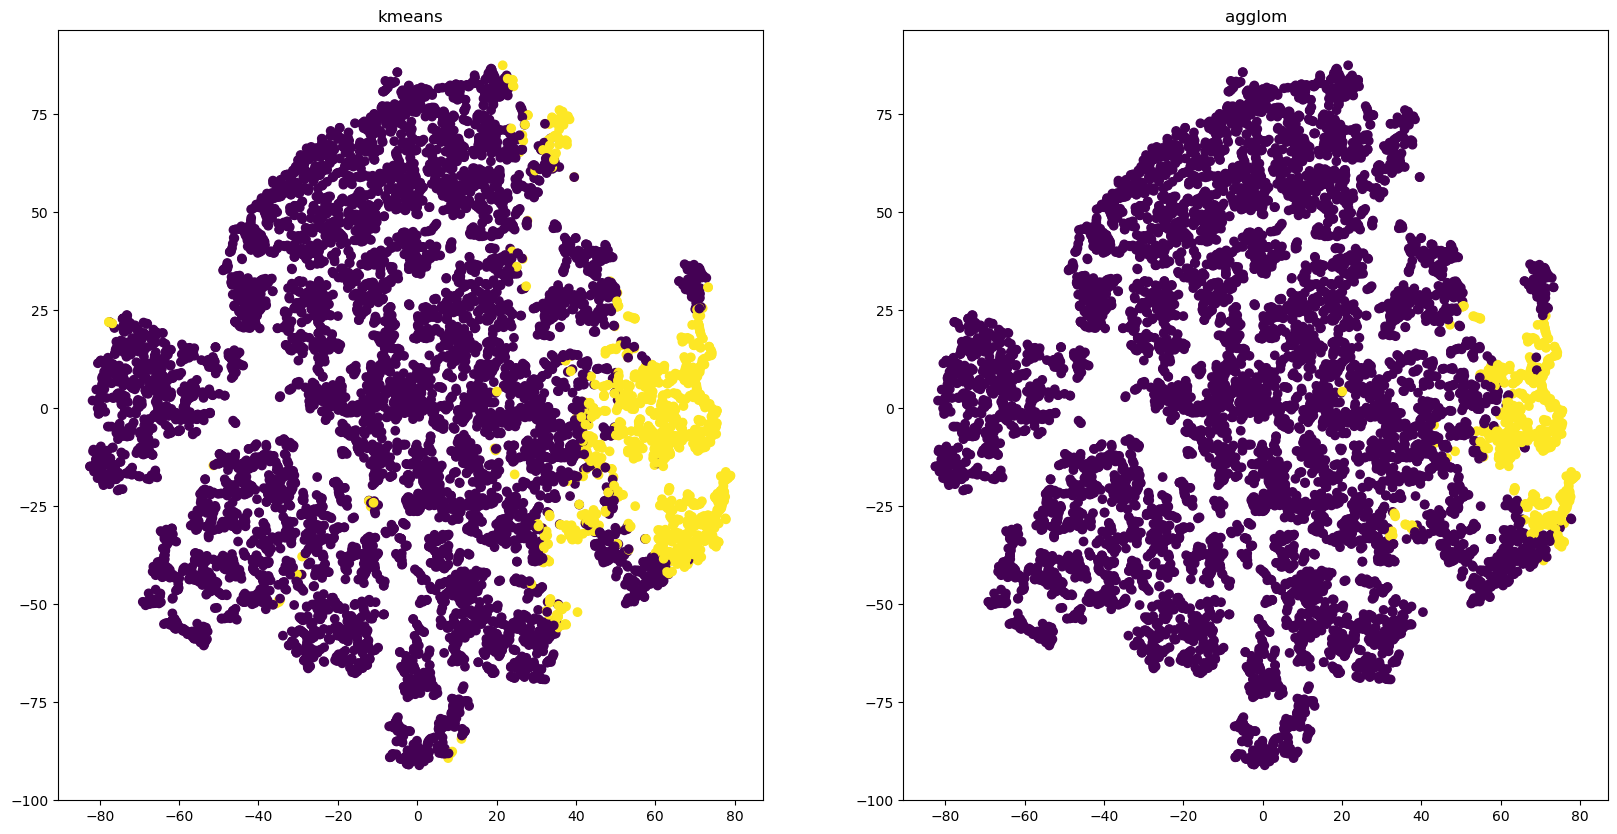

In [66]:
# visualize
plt.subplots(1,2,figsize = (20,10))
plt.subplot(1,2,1)
plt.scatter(tsne_data[:,0],tsne_data[:,1],c = (~final_kmeans.labels_.astype(bool)).astype(int))
plt.title("kmeans")
plt.subplot(1,2,2)
plt.scatter(tsne_data[:,0],tsne_data[:,1],c = final_agglom.labels_)
plt.title("agglom")
plt.show()


## Cluster evaluation (what does it all mean?)

In [67]:
# 1 . attach cluster labels back to original data
# 2 . and start doing EDA

df['kmeans'] = (~final_kmeans.labels_.astype(bool)).astype(int)
df['agglom'] = final_agglom.labels_

In [68]:
# start simple
# take descriptive stats (median/avg, ...)

# plots
# boxplots, pair plot (seaborn pair plot function), bar plots

# (inferential statistics for eda)
# are clusters statistically significantly different on the 16 numerical features

In [74]:
balance_diff = df.groupby(['kmeans']).describe()['balance'].T
balance_diff['ratio'] = balance_diff[1]/balance_diff[0]

In [82]:
np.round(balance_diff.loc[balance_diff.index == '50%','ratio'][0],2)

1.67

In [ ]:
# group 1 has higher balances

In [88]:
def column_compare(col):
    balance_diff = df.groupby(['kmeans']).describe()[col].T
    balance_diff['ratio'] = balance_diff[1]/balance_diff[0]

    #
    
    ratio = np.round(balance_diff.loc[balance_diff.index == '50%','ratio'][0],2)

    print(f"for {col} the ratio of medians between group 1 and group 0 is: {ratio} ")

        

In [89]:
for col in [col for col in df.columns if col != "kmeans"]:
    column_compare(col)

for balance the ratio of medians between group 1 and group 0 is: 1.67 
for balance_frequency the ratio of medians between group 1 and group 0 is: 1.0 
for purchases the ratio of medians between group 1 and group 0 is: 13.43 
for oneoff_purchases the ratio of medians between group 1 and group 0 is: inf 
for installments_purchases the ratio of medians between group 1 and group 0 is: 30.76 
for cash_advance the ratio of medians between group 1 and group 0 is: 0.0 
for purchases_frequency the ratio of medians between group 1 and group 0 is: 3.0 
for oneoff_purchases_frequency the ratio of medians between group 1 and group 0 is: inf 
for purchases_installments_frequency the ratio of medians between group 1 and group 0 is: 10.0 
for cash_advance_frequency the ratio of medians between group 1 and group 0 is: 0.0 
for cash_advance_trx the ratio of medians between group 1 and group 0 is: 0.0 
for purchases_trx the ratio of medians between group 1 and group 0 is: 9.2 
for credit_limit the ratio 

In [ ]:
# do overlayed histograms / or boxplots



In [ ]:
# make a model using the 16 features to predict kmeans group 0 or 1 - this will give us a lot of information.